# Spine Model


In [1]:
from numpy import *   #ones, cumsum, sum, isscalar
from matplotlib.pylab import * 
%matplotlib inline
plotose = True
import pickle

import PS_lib as lb
import PS_storage as st
import PS_tools as tools

from bootstrap import btset_cd, generateplots, btShInh, btShInhwpos
from data_Fullset import SCxL23 as exppar

# Parameter definitions
# Data is stored here      
data = st.dataStorage() # some default parameters defined.
data.dt = 0.05
data.NMDA = False

# Definition of the model.
lb.h.dt = data.dt
NMDA = data.NMDA
model = lb.loadNeuron("ball-2sticks.hoc",axon=False)

# Adding piece of dendritic branch with spine
model.addDend(name="dendShaft",locus="dendA1",L=2.1,D=0.87,ilocus=1)
model.addSpne(locus="dendShaft",ilocus=0.3333,L=1.0,D=1.0,Lneck=1.0,Dneck=0.15)
# Temperature of the neuron
lb.h.celsius = model.temperature
model.addDend(name="dendA2",locus=3,L=10.0,D=0.5,ilocus=1)
# Adding 2nd spine
model.addSpne(locus="dendShaft",ilocus=0.6666,L=1.0,D=1.0,Lneck=1.0,Dneck=0.15)


data.model = model.__dict__

model.soma.L = 20
#model.comp['B1'].L = 200
#model.comp['B1'].diam = 10
print(model.soma.L,model.soma.diam,model.soma(0.5).area(),model.dend[-1](0.5).area())

print("Topology:")
print(lb.h.topology())



	0 
	1 
	1 
	1 
	1 
20.0 29.78380012512207 1871.3713533814052 15.707963267948966
Topology:

|-|       soma(0-1)
   `|       dendA1prox(0-1)
     `|       dendA1(0-1)
       `|       dendShaft(0-1)
         `|       dendA2(0-1)
        `|       NSpne001(0-1)
          `|       Spne001(0-1)
        `|       NSpne000(0-1)
          `|       Spne000(0-1)
   `|       dendB1(0-1)

1.0


In [2]:
import PS_tools as tools


### Bootstrapping spines and synapses



In [3]:
nsp = 500
dis = btset_cd(cd='DiS',size=nsp)
sis = btset_cd(cd='SiS',size=nsp)
sps = btset_cd(cd='Sp',size=nsp)

dis['Rneck'] = dis['Rneck']#*2
sis['Rneck'] = sis['Rneck']#*2
sps['Rneck'] = sps['Rneck']#*2

iPSDsh = btShInh(size=nsp)


sp = model.spne[0]
sp.L = dis["L"].mean()
sp.diam = dis["D"].mean()

print("Area Volume Ah Vh")
print(sp(0.5).area(),sp(0.5).volume(),dis["Ah"][0]/dis["AhA0"][0],dis["Vh"][0])

Area Volume Ah Vh
1.4725267006695244 0.2690071568238925 0.36165280755697143 0.03698937244785129


In [4]:
gtrG = exppar.gtrG
gtrA = exppar.gtrA
gtrN = exppar.gtrN


### Excitatory synapse 

We need to define the arrival time and dynamics. These parameters may be modified later

In [5]:
model.AMPAlist = []
model.ncAMPAlist = []

tau1  = exppar.AMPAtaus[0]
tau2 = exppar.AMPAtaus[1]
AMPA0 = lb.h.Exp2Syn(1,sec = model.spne[0])
AMPA0.tau1 = tau1
AMPA0.tau2 = tau2
AMPA1 = lb.h.Exp2Syn(1,sec = model.spne[1])
AMPA1.tau1 = tau1
AMPA1.tau2 = tau2

gmax = gtrA*sps['A1'].mean()
stimE0=lb.h.NetStim(); stimE0.number = 1
stimE1=lb.h.NetStim(); stimE1.number = 1
NC0 = lb.h.NetCon(stimE0,AMPA0,0,0,gmax)
NC1 = lb.h.NetCon(stimE1,AMPA1,0,0,gmax)

model.AMPAlist.append(AMPA0)
model.AMPAlist.append(AMPA1)
model.ncAMPAlist.append(NC0)
model.ncAMPAlist.append(NC1)
NC0.delay = 10
NC1.delay = 10

# NMDA part
gmaxN = gtrN*sps['A1'].mean()
lb.add_NMDAsyns(model, locs=[[0,0.5]], gmax=gmaxN,tau2=20.0)  
NMDA0 = model.NMDAlist[0]
NCN0 = model.ncNMDAlist[0]
stimN0=lb.h.NetStim();stimN0.number = 1
NCN0 = lb.h.NetCon(stimN0,NMDA0,0,0,gmaxN)
model.ncNMDAlist[0] = NCN0
lb.add_NMDAsyns(model, locs=[[0,0.5]], gmax=gmaxN,tau2=20.0)  
NMDA1 = model.NMDAlist[1]
NCN1 = model.ncNMDAlist[1]
stimN1=lb.h.NetStim();stimN1.number = 1
NCN1 = lb.h.NetCon(stimN1,NMDA1,0,0,gmaxN)
model.ncNMDAlist[1] = NCN1
NMDA0.tau1 = exppar.NMDAtaus[0]
NMDA0.tau2 = exppar.NMDAtaus[1]
NMDA1.tau1 = exppar.NMDAtaus[0]
NMDA1.tau2 = exppar.NMDAtaus[1]

### Inhibitory synapse

In [6]:
gmaxG = gtrG*dis['A2'].mean()
GABA, NCG = lb.add_GABAsyns(model, locs=[[0,1]], spne=True, gmax=gmaxG,tau1=exppar.GABAtaus[0],tau2=exppar.GABAtaus[1])  


gmaxG = gtrG*iPSDsh.mean()
GABA2, NCG2 = lb.add_GABAsynscomp(model, model.comp['dendShaft'], loc = 0.1, gmax=gmaxG,tau1=exppar.GABAtaus[0],tau2=exppar.GABAtaus[1])  


In [7]:
lb.init_active(model, axon=False, soma=False, dend=False, dendNa=False,
                dendCa=False,spne=True)

# Recordings

In [8]:
trec, vrec = lb.h.Vector(), lb.h.Vector()
gRec, iRec,  vspneRec = [], [], []
gNMDA_rec, iNMDA_rec = [], []
trec.record(lb.h._ref_t)
vrec.record(model.soma(0.5)._ref_v)


#n=0
vDendRec = []
vRecn = {}
#For all dendrites
for dend in model.dend:
    #Adding vectors for Voltage, and Calcium
    vDendRec.append(lb.h.Vector())
    # Placing recording at mid-point in the dendritic branch
    vDendRec[-1].record(dend(0.5)._ref_v)
    vRecn[dend.name()] = vDendRec[-1]
    # NO CALCIUM!?!?!
#Probably better to organize them in a dictionary        
vDendRec[1].record(model.dend[1](1.0)._ref_v)

# Spine voltage recording stuff
vspneRec.append(lb.h.Vector())
vspneRec.append(lb.h.Vector())
sp0 = model.spne[0]
vspneRec[0].record(sp0(0.5)._ref_v)
sp1 = model.spne[1]
vspneRec[1].record(sp1(0.5)._ref_v)

# Calcium

caRecn = {}
caRecn['sp0 iCa'] = lb.h.Vector()
caRecn['sp1 iCa'] = lb.h.Vector()
caRecn['sp0 Ca'] = lb.h.Vector()
caRecn['sp1 Ca'] = lb.h.Vector()
caRecn['sp0 iCa'].record(sp0(0.5)._ref_ica) 
caRecn['sp1 iCa'].record(sp1(0.5)._ref_ica) 
caRecn['sp0 Ca'].record(sp0(1.0)._ref_cai)
caRecn['sp1 Ca'].record(sp1(1.0)._ref_cai) 


Vector[12]

In [9]:
vDendEL = []
dend = model.dend[1]
for i in range(10):
    vDendEL.append(lb.h.Vector())
    vDendEL[-1].record(dend((i+1.0)/10.0)._ref_v)

In [10]:
vDendEL2 = []
dend = model.dend[-1]
for i in range(10):
    vDendEL2.append(lb.h.Vector())
    vDendEL2[-1].record(dend((i+1.0)/10.0)._ref_v)

In [11]:
iRec.append(lb.h.Vector())
iRec.append(lb.h.Vector())
currentAMPA = iRec[0]

currentGABA = iRec[1]
iRec.append(lb.h.Vector())
currentNMDA = iRec[-1]
currentNMDA.record(NMDA1._ref_i)


Vector[35]

In [12]:
currentAMPA.record(AMPA0._ref_i)
currentGABA.record(GABA._ref_i)

Vector[34]

In [13]:
iRec.append(lb.h.Vector())
currentGABA2 = iRec[-1]
currentGABA2.record(GABA2._ref_i)


Vector[36]

## Small tuning parameters for dendrite?

In [14]:
dendsizeL0 = exppar.dendsizeL0
dendsizeL = max(max(max(dis['Dss'])+5,max(sis['Dss'])+5),150)
neck = model.neck[0]
Rneck = neck.L*1e-6/(neck.diam*1e-6/2.0)**2/pi*neck.Ra/100
dend = model.comp['dendA1prox']
dend.L = exppar.dendsizeL0
dend.diam = exppar.denddiam0

In [15]:
dendA2 = model.comp['dendA2']
dendA1 = model.comp['dendA1']
dendsh = model.comp['dendShaft']

dendA2.L = 1.0

In [16]:
dendsh.diam = exppar.dendDiam
dendA1.diam = exppar.dendDiam
dendA2.diam = exppar.dendDiam   

In [17]:
model.RM = exppar.rm
for sec in lb.h.allsec():
    sec.Ra = exppar.ra
    sec.cm = 1.0
    sec.g_pas = 1.0/model.RM

factor = exppar.factor2nddend
model.comp['dendB1'].cm = factor
model.comp['dendB1'].g_pas = factor/model.RM
model.comp['dendB1'].L = exppar.len2nddend
model.comp['dendB1'].diam = 1

In [18]:
rhosp = 1.3
diamneck = sps['meanDneck'].mean()/1e3
dendareaperL = rhosp*(mean(sps['Ah'])+(pi*diamneck))
factor = dendareaperL/(pi*dendA1.diam)
print(factor)
factorsp = factor
factordd = (pi*dendA1.diam-(pi*diamneck**2/4.0)*rhosp)/(pi*dendA1.diam)
print(factordd,factordd+factorsp)

factor = factordd+factorsp
factor = exppar.factorspinesdend
dendA2.cm = factor
dendA1.cm = factor

dendA2.g_pas = factor/model.RM
dendA1.g_pas = factor/model.RM

2.783361169371185
0.9762894361485808 3.7596506055197656


In [19]:
dendA1.nseg = int(dendA1.L//10)+1
dendA2.nseg = int(dendA2.L//10)+1

dendA1.nseg = 10
dendA2.nseg = 10
print(dendA1.nseg,dendA2.nseg)

10 10


In [20]:
diam0 = 0.15
#Rneck0 = Rneck/1e6
#Cm0 = model.CM


In [21]:
Rneck0 = neck.Ra*sps['Lneck']/(diam0)**2*0.04/pi
#print(Rneck0,data[i,3])
#diams = diam0*sqrt(Rneck0/sps['Rneck'])
#hist(diams, 51,density = True)
#hist(sps['minDneck']/1e3,51,alpha=0.7,density = True)
#hist(sps['meanDneck']/1e3,51,alpha=0.7,density = True)

In [22]:
model.dend

[dendA1prox, dendA1, dendB1, dendShaft, dendA2]

In [23]:
Rdendprox = model.comp['dendA1prox'].L*1e-6/2.0*model.comp['dendA1prox'].Ra/100/(pi*(model.comp['dendA1prox'].diam*1e-6/2.0)**2)
diam0 = 0.15

def simulateSet2sp(model,spn,spn2,tG = 500,ton = 50, dton2 = 0,
                toffset = 50,t_stop = 250, EL = -65,
                btsr = None,VDCC = array([0.,0,0,0]), 
                dendrec = True, inh = 'in', silent = None,iPSDsh = None):
    if btsr is None:
        btsr = ones(9)==0
    model.E_PAS = EL
    model.soma.e_pas = model.E_PAS
    for dendp in model.dend:
        dendp.e_pas = model.E_PAS
    for sp in model.spne:
        sp.e_pas = model.E_PAS

    dendsh = model.comp['dendShaft']
    dendA1 = model.comp['dendA1']
    dendA2 = model.comp['dendA2']
    
    neck0 = model.neck[0]
    sp0 = model.spne[0]
    neck1 = model.neck[1]
    sp1 = model.spne[1]

    dshL = dendsh.L
    dendsizeL = dendsh.L+dendA1.L+dendA2.L
    data = column_stack((spn["A1"],spn["A1"],spn["A2"],
                         spn["Rneck"],spn["Dss"],spn["Lhead"],
                         spn["D"],spn["Ln"],spn["AhA0"], 
                         spn["meanDneck"]/1e3))
    data2 = column_stack((spn2["A1"],spn2["Rneck"],spn2["Lhead"],
                          spn2["D"],spn2["Ln"],spn2["AhA0"]))

    if isnan(data).sum()>0:
        raise "There are nans, do something about it!"
    for i in range(9):
        if ~btsr[i]:
            data[:,i] = data[:,i].mean()
         
    nsp = data.shape[0]
    if iPSDsh is None:
        iPSDsh = zeros(nsp)
    mes = zeros((nsp,9))
    me2 = zeros((nsp,11))
    me3 = zeros((nsp,10))

    iad = 2
    vavg = zeros((int(t_stop/lb.h.dt)+iad,7))
    vtracs = zeros((int(t_stop/lb.h.dt)+iad,nsp))
    vtracs2 = zeros((int(t_stop/lb.h.dt)+iad,nsp))
    Ctracs2 = zeros((int(t_stop/lb.h.dt)+iad,nsp))
    Ctracs = zeros((int(t_stop/lb.h.dt)+iad,nsp))
    vtracsD = zeros((int(t_stop/lb.h.dt)+iad,nsp))
    vtracsS = zeros((int(t_stop/lb.h.dt)+iad,nsp))
    for i in arange(nsp):
        NC0.weight[0]  = data[i,0] *gtrA
        NCN0.weight[0] = data[i,1] *gtrN
        NC1.weight[0]  = data2[i,0] *gtrA
        NCN1.weight[0] = data2[i,0] *gtrN
        if silent == 'sp0':
            NC0.weight[0] = 0
            NCN0.weight[0] = 0
        elif silent == 'sp1':
            NC1.weight[0]  = 0
            NCN1.weight[0] = 0
        elif silent == 'both':
            NC0.weight[0] = 0
            NCN0.weight[0] = 0
            NC1.weight[0]  = 0
            NCN1.weight[0] = 0
            
        if inh == 'in':
            NCG.weight[0] = data[i,2] *gtrG
            NCG2.weight[0] = 0.0
        elif inh =='out':
            NCG.weight[0] = 0.0
            NCG2.weight[0] = iPSDsh[i] *gtrG
        else:
            NCG.weight[0] = 0.0
            NCG2.weight[0] = 0.0
            
            

        neck0.L = data[i,7]  
        Rneck0 = neck.Ra*neck0.L/(diam0)**2*0.04/pi
        neck0.diam = diam0*sqrt(Rneck0/data[i,3])
        
        neck1.L = data2[i,2]  
        Rneck1 = neck.Ra*neck1.L/(diam0)**2*0.04/pi
        neck1.diam = diam0*sqrt(Rneck1/data2[i,1])
        
        posD = data[i,4]
        
        dendA1.L = posD-dshL/2
        dendA2.L = dendsizeL-posD-dshL/2

        
        # A = pi*D**2
        sp0.L = data[i,5]
        sp0.diam = data[i,6]
        sp0.cm = data[i,8]
        
        CaTcond = 1e-3# pS
        sp0.pbar_caL13PS = VDCC[0]*CaTcond#/spineArea
        sp0.pbar_caLPS = VDCC[1]*CaTcond#/spineArea
        sp0.pbar_canPS = VDCC[2]*CaTcond#/spineArea
        sp0.pcaqbar_caqPS = VDCC[3]*CaTcond#/spineArea
        
        
        sp1.L = data2[i,2]
        sp1.diam = data2[i,3]
        sp1.cm = data2[i,5]
        sp1.pbar_caL13PS = VDCC[0]*CaTcond#/spineArea
        sp1.pbar_caLPS = VDCC[1]*CaTcond#/spineArea
        sp1.pbar_canPS = VDCC[2]*CaTcond#/spineArea
        sp1.pcaqbar_caqPS = VDCC[3]*CaTcond#/spineArea
        
        
        NC0.delay = toffset+ton-50
        NCN0.delay = toffset+ton-50
        
        NC1.delay = toffset+ton+dton2-50
        NCN1.delay = toffset+ton+dton2-50
        
        NCG.delay = toffset+tG
        NCG2.delay = toffset+tG

        for il in range(10):
            f = 1-7.5*il/dendA1.L
            #f = 0.5
            if f>=0:
                vDendEL[il].record(dendA1(f)._ref_v)
            else:
                vDendEL[il].record(dendA1(0.0)._ref_v)
        
        for il in range(10):
            f = 7.5*il/dendA2.L
            #f = 0.5
            if f<=1:
                vDendEL2[il].record(dendA2(f)._ref_v)
            else:
                vDendEL2[il].record(dendA2(1.0)._ref_v)
                
        lb.h.finitialize(model.E_PAS)

                    
        lb.neuron.run(t_stop)
        
        
        current = abs((array(vDendRec[0])-array(vrec[0]))/Rdendprox)
        
        vtracs[:,i] = array(vspneRec[0]) 
        vtracs2[:,i] = array(vspneRec[1]) 
        
        if dendrec:
            vtracsD[:,i] = array(vDendRec[1])
        else:
            vtracsD[:,i] = array(vDendEL[2])
            
        vtracsS[:,i] = array(vrec) 

        vavg[:,0] += array(vspneRec[0]) 
        vavg[:,1] += array(vspneRec[0])**2
        vavg[:,2] += array(vDendRec[1]) 
        vavg[:,3] += array(vDendRec[1])**2
        vavg[:,4] += array(vrec) 
        vavg[:,5] += array(vrec)**2
        vavg[:,6] += 1
            
        cat = array(caRecn['sp0 Ca'])/1e-3
        Ctracs[:,i] = cat-cat[0] 
        cat = array(caRecn['sp1 Ca'])/1e-3
        Ctracs2[:,i] = cat-cat[0] 
        
        if inh=='out':
            aG = abs(array(currentGABA2)).argmax()
            maxGABA = array(currentGABA2)[aG]
        else:
            aG = abs(array(currentGABA)).argmax()
            maxGABA = array(currentGABA)[aG]

            
        aA = abs(array(currentAMPA)).argmax()
        aN = abs(array(currentNMDA)).argmax()
        
        mes[i,:] = [data[i,3],max(vspneRec[0])-EL,
                    max(vDendRec[3])-EL,max(vrec)-EL,
                    max(cat)-cat[0],maxGABA,
                    array(currentAMPA)[aA],max(abs(current)),
                    array(currentNMDA)[aN]]
        me2[i,0] = max(vDendRec[3])
        me2[i,1:] = [max(vD) for vD in vDendEL]
        me3[i,:] = [max(vD) for vD in vDendEL2]


        
    vavg[:,:5] = vavg[:,:5]/vavg[0,6]
    vavg[:,1] = sqrt(vavg[:,1]-vavg[:,0]**2)#/sqrt(vavg[0,6])
    vavg[:,3] = sqrt(vavg[:,3]-vavg[:,2]**2)#/sqrt(vavg[0,6])
    vavg[:,5] = sqrt(vavg[:,5]-vavg[:,4]**2)#/sqrt(vavg[0,6])
    return(vavg,mes,vtracs,vtracsD,vtracsS,
           Ctracs,me2,me3,array(trec),vtracs2,Ctracs2)

In [24]:
VDCCa =  array([0.04023183, 0.08000483, 0.03416801, 0.02747762] )
EL0 = -70

In [25]:
#vavg0,mes0,vtracs0,vtracsD0,vtracsS0,Ctracs0,me20,me30, trec = simulateSet(model,dis,tG = 100,ton = 50,toffset = 100,t_stop = 500, EL = EL0,btsr = ones(9)==1,VDCC = VDCCa, dendrec=False)
#plot(arange(vtracs0.shape[0])*lb.h.dt,vtracs0[:,0])

In [26]:
from PS_tools import *
from scipy.signal import find_peaks
from bootstrap import  ShInhwpos,btShInhwpos

# 2 spines conditions

In [27]:
def getvpeaks(vtracs2b,vtracs2,vtracs2c, th = 0.5, plotose = False,):
    vt = 1.0*vtracs2b
    lpeaks = list(map(lambda x: (find_peaks(x-min(x),height=th)[1]['peak_heights'].max(), min(x)) , vt.transpose()))
    apeaks = array(lpeaks)
    apeaks[:,0] = apeaks[:,0]+apeaks[:,1]
    if plotose:
        hist(apeaks[:,0]+65,bins=51,label= 'baseline',alpha=0.7)
    ap0 = apeaks[:,0]
    vt = 1.0*vtracs2c
    lpeaks = list(map(lambda x: (find_peaks(x-min(x),height=th)[1]['peak_heights'].max(), min(x)) , vt.transpose()))
    apeaks = array(lpeaks)
    apeaks[:,0] = apeaks[:,0]+apeaks[:,1]
    if plotose:
        hist(apeaks[:,0]+65,bins=51,label= 'SiS',alpha=0.7)
    ap0 = column_stack((ap0,apeaks[:,0]))

    vt = 1.0*vtracs2
    lpeaks = list(map(lambda x: (find_peaks(x-min(x),height=th)[1]['peak_heights'].max(), min(x)) , vt.transpose()))
    apeaks = array(lpeaks)
    apeaks[:,0] = apeaks[:,0]+apeaks[:,1]
    if plotose:
        hist(apeaks[:,0]+65,bins=51,label= 'DiS',alpha=0.7)
        legend()
    ap0 = column_stack((ap0,apeaks[:,0]))
    ap0 = ap0
    return(ap0)

In [28]:
iPSDsh = btShInh(size=500)


In [30]:
res = simulateSet2sp(model,dis,sps,tG = 10,
                      ton = 50,dton2 = 15,toffset = 100,
                      t_stop = 500, EL = -40,
                      btsr = ones(9)==1,VDCC = VDCCa, 
                      inh = 'in',silent = 'both', iPSDsh = iPSDsh)
_,_,vtracs0,vtracsD0,vtracsS0,Ctracs0,_,_,_,vtracs2,Ctracs2 = res


In [35]:
res = simulateSet2sp(model,dis,sps,tG = 500,
                      ton = 50,dton2 = 15,toffset = 100,
                      t_stop = 500, EL = -70,
                      btsr = ones(9)==1,VDCC = VDCCa, 
                      inh = 'in',silent = 'sp0', iPSDsh = iPSDsh)
_,_,vtracs0b,vtracsD0b,vtracsS0b,Ctracs0b,_,_,_,vtracs2b,Ctracs2b = res


/export/home1/users/bssn/serna/environments/neuron/lib/python3.6/site-packages/ipykernel_launcher.py:200: RuntimeWarning: invalid value encountered in sqrt


(150, 200)

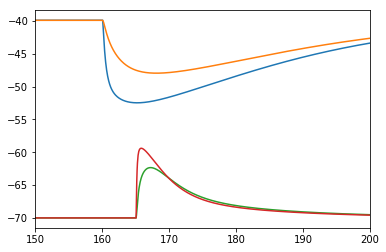

In [36]:
trec = arange(vtracs0.shape[0])*0.05
plot(trec,vtracs0[:,0])
plot(trec,vtracs2[:,0])
plot(trec,vtracs0b[:,0])
plot(trec,vtracs2b[:,0])
xlim(150,200)

In [29]:
dis = btset_cd(cd='DiS',size=nsp)
sps = btset_cd(cd='Sp',size=nsp)
sis = btset_cd(cd='SiS',size=nsp)
iPSDsh = btShInh(size=nsp)

dendsizeL = max(max(concatenate((dis['Dss'],sps['Dss'])))+5,150)
dendA1.L = dendsizeL-10
dendA2.L = 8 -dendsh.L

nsp = 500

for i in range(50):
    res = simulateSet2sp(model,dis,sps,tG = 10,
                      ton = 50,dton2 = 0.0,toffset = 100,
                      t_stop = 500, EL = -70,
                      btsr = ones(9)==1,VDCC = VDCCa, 
                      inh = 'in',silent = 'sp0', iPSDsh = iPSDsh)
    _,_,vtracs0,vtracsD0,vtracsS0,Ctracs0,_,_,_,vtracs2,Ctracs2 = res
    res = simulateSet2sp(model,dis,sps,tG = 500,
                      ton = 50,dton2 = 0.0,toffset = 100,
                      t_stop = 500, EL = -70,
                      btsr = ones(9)==1,VDCC = VDCCa, 
                      inh = 'in',silent = 'sp0', iPSDsh = iPSDsh)
    _,_,vtracs0b,vtracsD0b,vtracsS0b,Ctracs0b,_,_,_,vtracs2b,Ctracs2b = res
    res = simulateSet2sp(model,dis,sps,tG = 10,
                      ton = 50,dton2 = 0.0,toffset = 100,
                      t_stop = 500, EL = -70,
                      btsr = ones(9)==1,VDCC = VDCCa, 
                      inh = 'out',silent = 'sp0', iPSDsh = iPSDsh)
    _,_,vtracs0c,vtracsD0c,vtracsS0c,Ctracs0c,_,_,_,vtracs2c,Ctracs2c = res
    
    ap0 = getvpeaks(vtracs2b,vtracs2,vtracs2c, th = 0.5, plotose = False)
    apS = getvpeaks(vtracsS0b,vtracsS0,vtracsS0c, th = 0.02, plotose = False)
    apD = getvpeaks(vtracsD0b,vtracsD0,vtracsD0c, th = 0.02, plotose = False)
    apC = getvpeaks(Ctracs2b,Ctracs2,Ctracs2c, th = 0., plotose = False)
    
 

    res = simulateSet2sp(model,dis,sps,tG = -5,ton = 50,
                      dton2 = 15,toffset = 100,t_stop = 500, 
                      EL = -70,btsr = ones(9)==1,VDCC = VDCCa, 
                      inh = 'in',silent = 'sp1', iPSDsh = iPSDsh)
    _,_,vtracs0,vtracsD0,vtracsS0,Ctracs0,_,_,_,vtracs2,Ctracs2  = res
    res = simulateSet2sp(model,dis,sps,tG = 500,
                      ton = 50,dton2 = 15,toffset = 100,
                      t_stop = 500, EL = -70,
                      btsr = ones(9)==1,VDCC = VDCCa, 
                      inh = 'in',silent = 'sp1', iPSDsh = iPSDsh)
    _,_,vtracs0b,vtracsD0b,vtracsS0b,Ctracs0b,_,_,_,vtracs2b,Ctracs2b =  res
    res = simulateSet2sp(model,dis,sps,tG = -5,ton = 50,
                      dton2 = 15,toffset = 100,t_stop = 500, 
                      EL = -70,btsr = ones(9)==1,VDCC = VDCCa, 
                      inh = 'out',silent = 'sp1', iPSDsh = iPSDsh)
    _,_,vtracs0c,vtracsD0c,vtracsS0c,Ctracs0c,_,_,_,vtracs2c,Ctracs2c  = res 
    
    bp0 = getvpeaks(vtracs0b,vtracs0,vtracs0c, th = 0.5, plotose = False)
    bpS = getvpeaks(vtracsS0b,vtracsS0,vtracsS0c, th = 0.02, plotose = False)
    bpD = getvpeaks(vtracsD0b,vtracsD0,vtracsD0c, th = 0.02, plotose = False)
    bpC = getvpeaks(Ctracs0b,Ctracs0,Ctracs0c, th = 0.00, plotose = False)
    
    ap0 = column_stack((ap0,bp0))
    apS = column_stack((apS,bpS))
    apD = column_stack((apD,bpD))
    apC = column_stack((apC,bpC))
    
    datat = column_stack((dis['A1'],dis['A2'],sps['A1'],
                          iPSDsh,dis['Rneck'],sps['Rneck'],dis['Dss'],sps['Dss']))
    
    if i == 0:
        fap0 = ap0+70
        fapS = apS+70
        fapD = apD+70
        fapC = apC*1.0
        fdat = datat*1.0
    else:
        fap0 = row_stack((fap0,ap0+70))
        fapS = row_stack((fapS,apS+70))
        fapD = row_stack((fapD,apD+70))
        fapC = row_stack((fapC,apC))
        fdat = row_stack((fdat,datat))

    
    dis = btset_cd(cd='DiS',size=nsp)
    sps = btset_cd(cd='Sp',size=nsp)
    sis = btset_cd(cd='Sp',size=nsp)

    iPSDsh = btShInh(size=nsp)
    
    dendsizeL = max(max(concatenate((dis['Dss'],sps['Dss'])))+5,150)
    dendA1.L = dendsizeL-10
    dendA2.L = 8 -dendsh.L

    if i%5 == 0: 
        print(i)
        with open("gatinginfov2_temp.pickle","wb") as f:
            pickle.dump([fapS,fapD,fap0,fapC,fdat],f)


with open("gatinginfov2_.pickle","wb") as f:
    pickle.dump([fapS,fapD,fap0,fapC,fdat],f)


KeyboardInterrupt: 

In [ ]:
ap0 = getvpeaks(vtracs2b,vtracs2,vtracs2c, th = 0.5, plotose = False)
apS = getvpeaks(vtracsS0b,vtracsS0,vtracsS0c, th = 0.02, plotose = False)
apD = getvpeaks(vtracsD0b,vtracsD0,vtracsD0c, th = 0.02, plotose = False)
apC = getvpeaks(Ctracs2b,Ctracs2,Ctracs2c, th = 0., plotose = False)
